In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import evaluate
import torch
import torch.nn as nn
from tqdm import tqdm

from helper_functions import ReviewDataset, plot_training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

2024-06-14 17:08:01.232199: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 17:08:01.953024: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


cuda


In [3]:
data = pd.read_csv('train_data.csv')
display(data)

,review,rating
0,location not palace excellent hotel booke dthe...,4
1,respite definitely not place stay looking ultr...,3
2,stunning truly memorable spot right beach nusa...,4
3,solid business hotel near embassy stayed hotel...,3
4,nice place make sure lock money warning money ...,3
...,...,...
16387,great base explore new york stayed 4 nights en...,4
16388,wonderful advert paris wonderful introduction ...,4
16389,ideal relaxing holdiay rachel jay green liverp...,3
16390,"watch food, husband went resort 4 nights chris...",2


<AxesSubplot: >

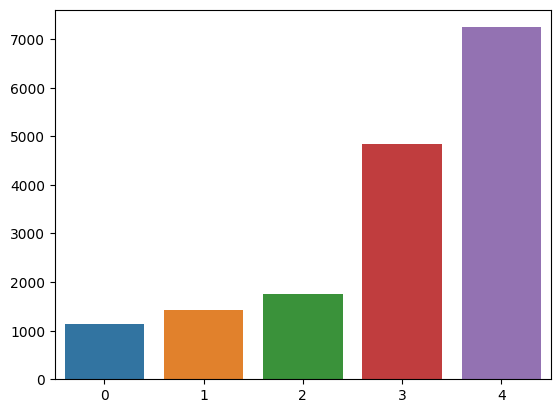

In [13]:
fig, ax = plt.subplots()
counts = data['rating'].value_counts()
sns.barplot(x=counts.index, y=counts.values, ax=ax)

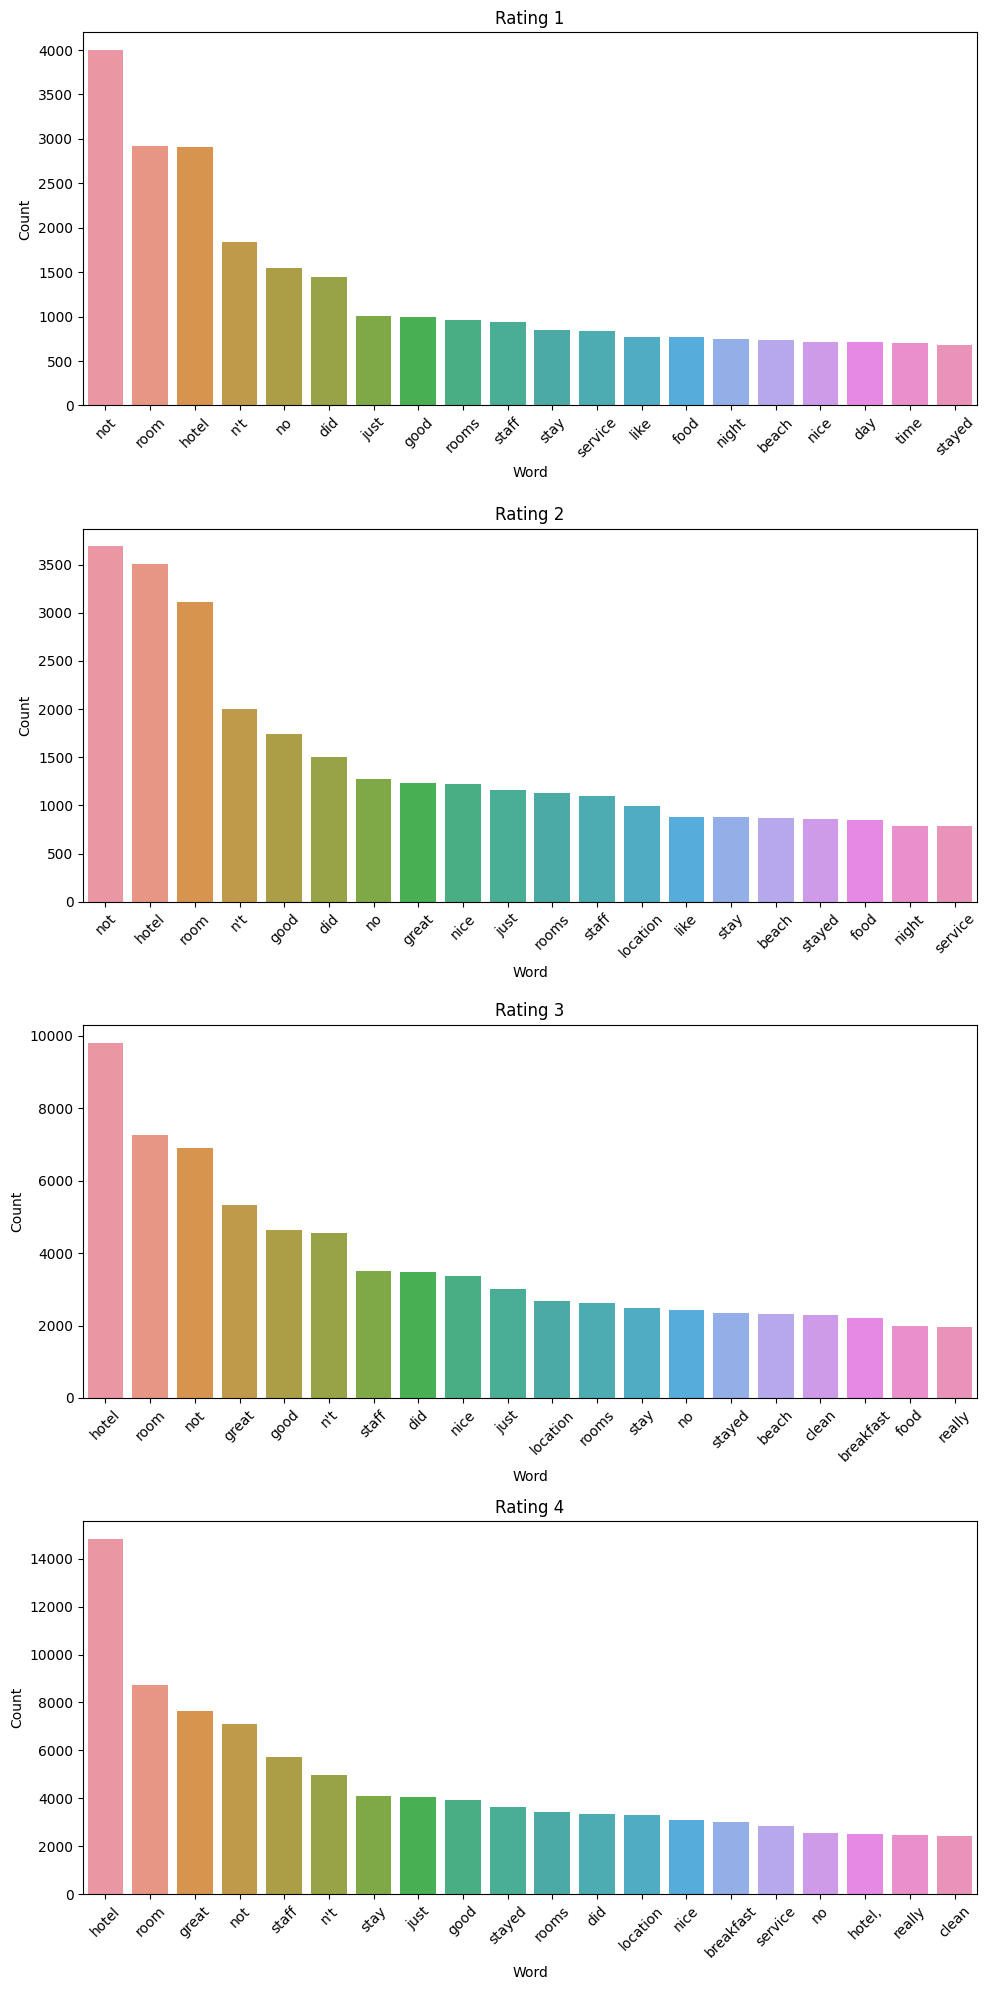

In [22]:
reviews = {
    0: {},
    1: {},
    2: {},
    3: {},
    4: {}
}
for idx, row in data.iterrows():
    rating = row['rating']
    review = row['review']
    for word in review.split():
        if word in reviews[rating]:
            reviews[rating][word] += 1
        else:
            reviews[rating][word] = 1
            
fig, ax = plt.subplots(4, 1, figsize=(10, 20))
for i in range(1, 5):
    words = list(reviews[i].keys())
    counts = list(reviews[i].values())
    sorted_words = [(word, count) for count, word in sorted(zip(counts, words), reverse=True)]
    sns.barplot(x=[word for word, count in sorted_words[:20]], y=[count for word, count in sorted_words[:20]], ax=ax[i-1])
    ax[i-1].set_title(f'Rating {i}')
    ax[i-1].set_xticklabels(ax[i-1].get_xticklabels(), rotation=45)
    ax[i-1].set_xlabel('Word')
    ax[i-1].set_ylabel('Count')
    
plt.tight_layout()

In [4]:
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
text8 = api.load("text8")
word2vec = Word2Vec(text8, min_count=1)

In [5]:
def tokenize_data(data, tokenizer):
    data_tokenized = []
    for review in data:
        unknows = 0
        all_parsed = 0
        review_tokenized = []
        for word in review.split():
            all_parsed+=1
            try:
                review_tokenized.append(tokenizer[word.lower()])
            except:
                unknows +=1
        data_tokenized.append(review_tokenized)
    return data_tokenized
    
def pad_data(data, max_len):
    data_padded = []
    for review in data:
        if len(review) < max_len:
            review += [0] * (max_len - len(review))
        else:
            review = review[:max_len]
        data_padded.append(review)
    return data_padded

In [6]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X_train, X_val, y_train, y_val = train_test_split(data['review'], data['rating'], test_size=0.2, random_state=42, stratify=data['rating'])
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42, stratify=y_val)

emb_weights = torch.FloatTensor(word2vec.wv.vectors)
max_len = data['review'].apply(lambda x: len(x.split())).max()

X_train_tokenized = tokenize_data(X_train, word2vec.wv.key_to_index)
X_val_tokenized = tokenize_data(X_val, word2vec.wv.key_to_index)
X_test_tokenized = tokenize_data(X_test, word2vec.wv.key_to_index)
X_train_padded = pad_data(X_train_tokenized, max_len)
X_val_padded = pad_data(X_val_tokenized, max_len)
X_test_padded = pad_data(X_test_tokenized, max_len)
X_resampled, y_resampled = SMOTE().fit_resample(X_train_padded, y_train)

train_dataset = ReviewDataset(X_resampled, y_resampled)
val_dataset = ReviewDataset(X_val_padded, y_val)
test_dataset = ReviewDataset(X_test_padded, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, out_size, emb_weights, max_length, hidden_layers=1, dropout=0.2, bidirectional=False):
        super(LSTMRegressor, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = 2 if bidirectional else 1
        self.embeddings = nn.Embedding.from_pretrained(emb_weights)
        self.embeddings.requires_grad = False

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, bidirectional=bidirectional, dropout=0.4)
        self.fc_in = nn.Linear(hidden_size * self.bidirectional * max_length, hidden_size)
        self.layers = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.Dropout(dropout)
            ) for _ in range(hidden_layers)]
        )
        self.fc_out = nn.Linear(hidden_size, out_size)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers * self.bidirectional, batch_size, self.hidden_size)
        state = torch.zeros(self.num_layers * self.bidirectional, batch_size, self.hidden_size)
        return hidden, state

    def forward(self, x, hidden):
        x = self.embeddings(x)
        x = x.transpose(0, 1)
        all_outputs, hidden = self.lstm(x, hidden)
        all_outputs = all_outputs.transpose(0, 1)
        out = all_outputs.contiguous().view(all_outputs.size(0), -1)
        x = self.fc_in(out)
        for layer in self.layers:
            x = self.LeakyReLU(layer(x))
        x = self.fc_out(x)
        return x, hidden
     
lstm_model = LSTMRegressor(100, 100, 1, 5, emb_weights, bidirectional = True, max_length=max_len).to(device)
lstm_model

/home/bruno/OneDrive/homework/studia/SEM4/SSNE/LAB/projekty/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTMRegressor(
  (embeddings): Embedding(253854, 100)
  (lstm): LSTM(100, 100, dropout=0.4, bidirectional=True)
  (fc_in): Linear(in_features=386200, out_features=100, bias=True)
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.2, inplace=False)
    )
  )
  (fc_out): Linear(in_features=100, out_features=5, bias=True)
  (LeakyReLU): LeakyReLU(negative_slope=0.2)
)

In [8]:
def train(model, train_loader, val_loader, epochs, criterion, optimizer, eval_fn, device, verbose=True):
    loss_history = []
    val_eval_history = []
    train_eval_history = []
    model.train()
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0
        for idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            hidden, state = model.init_hidden(data.shape[0])
            hidden, state = hidden.to(device), state.to(device)
            optimizer.zero_grad()
            out, hidden = model(data, (hidden, state))
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        if verbose:
            print(f'Epoch {epoch+1}/{epochs} - Train loss: {train_loss}')
        loss_history.append(train_loss)
        val_eval = eval_fn(model, val_loader, device)
        train_eval = eval_fn(model, train_loader, device)
        if verbose:
            print(f'Val accuracy: {val_eval}, Train accuracy: {train_eval}')
        val_eval_history.append(val_eval)
        train_eval_history.append(train_eval)
    return loss_history, val_eval_history, train_eval_history

def get_accuracy(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            hidden, state = model.init_hidden(data.shape[0])
            hidden, state = hidden.to(device), state.to(device)
            out, hidden = model(data, (hidden, state))
            _, predicted = torch.max(out, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct / total

In [8]:
optimizer = torch.optim.Adam(lstm_model.parameters(), lr = 0.001)
loss_fun = nn.CrossEntropyLoss()

loss_history, val_eval_history, train_eval_history = train(lstm_model, train_loader, val_loader, 10, loss_fun, optimizer, get_accuracy, device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Train loss: 1.2523285108423128


 10%|█         | 1/10 [00:49<07:26, 49.60s/it]

Val accuracy: 0.4008541793776693, Train accuracy: 0.3643424231964101
Epoch 2/10 - Train loss: 1.0902653089816996


 20%|██        | 2/10 [01:39<06:35, 49.50s/it]

Val accuracy: 0.546064673581452, Train accuracy: 0.6210562651018294
Epoch 3/10 - Train loss: 0.8807341230757716


 30%|███       | 3/10 [02:53<07:05, 60.83s/it]

Val accuracy: 0.5027455765710799, Train accuracy: 0.740006903693476
Epoch 4/10 - Train loss: 0.6468910956488013


 40%|████      | 4/10 [03:40<05:32, 55.46s/it]

Val accuracy: 0.5668090298962782, Train accuracy: 0.8486710390058682
Epoch 5/10 - Train loss: 0.45197906776045593


 50%|█████     | 5/10 [04:26<04:19, 51.89s/it]

Val accuracy: 0.5692495424039048, Train accuracy: 0.9154297549188816
Epoch 6/10 - Train loss: 0.3350960947326477


 60%|██████    | 6/10 [05:40<03:58, 59.66s/it]

Val accuracy: 0.5558267236119585, Train accuracy: 0.9429754918881602
Epoch 7/10 - Train loss: 0.24973572143014297


 70%|███████   | 7/10 [06:27<02:46, 55.38s/it]

Val accuracy: 0.4966442953020134, Train accuracy: 0.9644459785985502
Epoch 8/10 - Train loss: 0.20724977561936736


 80%|████████  | 8/10 [07:14<01:45, 52.64s/it]

Val accuracy: 0.5265405735204393, Train accuracy: 0.9096996893337935
Epoch 9/10 - Train loss: 0.16233453237519457


 90%|█████████ | 9/10 [08:29<00:59, 59.60s/it]

Val accuracy: 0.5204392922513728, Train accuracy: 0.9790127718329307
Epoch 10/10 - Train loss: 0.15177554352245978


100%|██████████| 10/10 [09:17<00:00, 55.79s/it]

Val accuracy: 0.5186089078706528, Train accuracy: 0.9830169140490163


In [10]:
torch.save(lstm_model.state_dict(), 'lstm_model.pth')

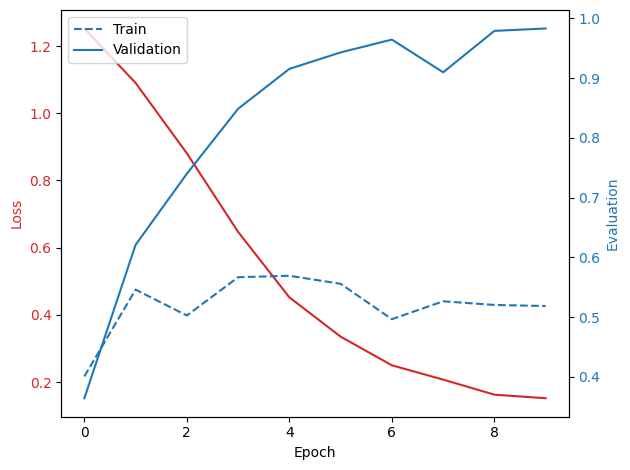

In [9]:
plot_training(loss_history, val_eval_history, train_eval_history)

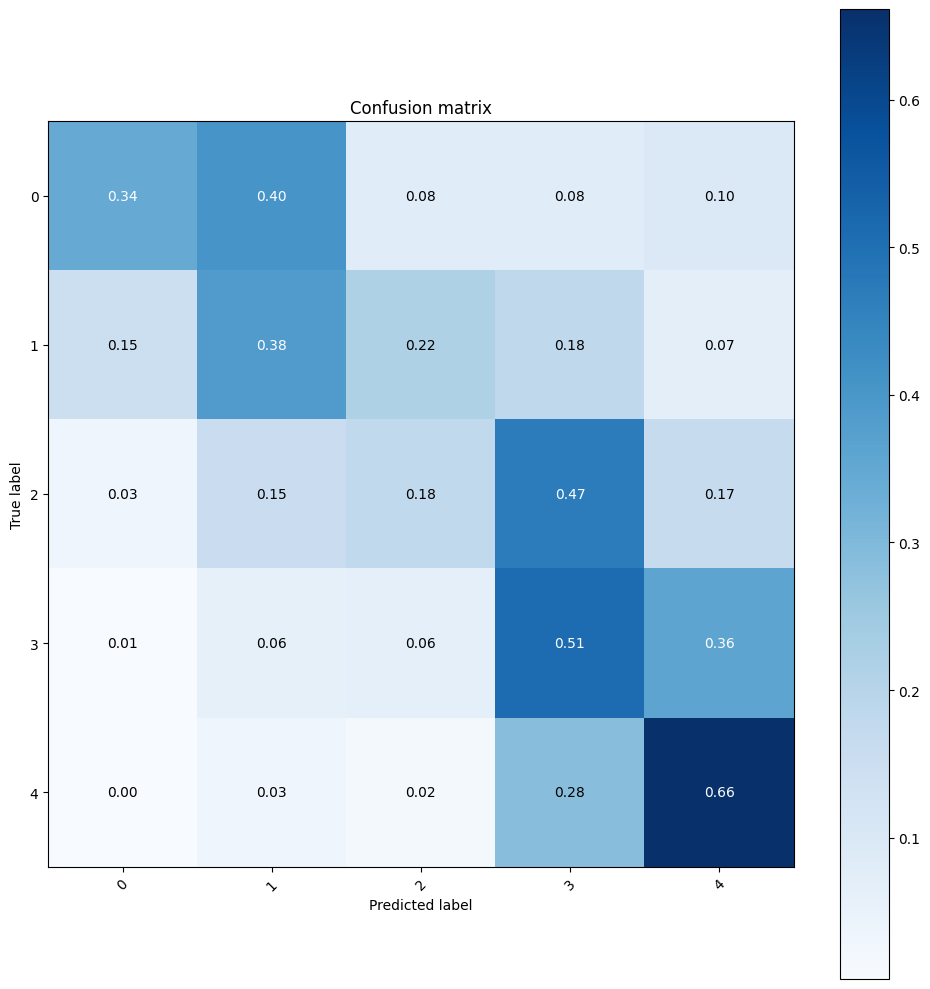

In [11]:
from helper_functions import plot_confusion_matrix

confusion_matrix = evaluate.load('confusion_matrix')
lstm_model.eval()
with torch.no_grad():
    target_list = []
    output_list = []
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        hidden, state = lstm_model.init_hidden(data.shape[0])
        hidden, state = hidden.to(device), state.to(device)
        out, hidden = lstm_model(data, (hidden, state))
        _, predicted = torch.max(out, 1)
        target_list.extend(target.cpu().numpy())
        output_list.extend(predicted.cpu().numpy())
    confusion_matrix = confusion_matrix.compute(references=target_list, predictions=output_list)
cm = torch.tensor(confusion_matrix["confusion_matrix"])
plot_confusion_matrix(cm, classes=[0, 1, 2, 3, 4])

## Wybór najlepszego modelu

In [9]:
def train_early_stopping(model, train_loader, val_loader, epochs, criterion, optimizer, eval_fn, device, patience=3, delta=0.02, verbose=True):
    loss_history = []
    val_eval_history = []
    train_eval_history = []
    best_val = 0
    patience_counter = 0
    model.train()
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0
        for idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            hidden, state = model.init_hidden(data.shape[0])
            hidden, state = hidden.to(device), state.to(device)
            optimizer.zero_grad()
            out, hidden = model(data, (hidden, state))
            out = nn.functional.softmax(out, dim=1)
            target = nn.functional.one_hot(target, num_classes=5).float()
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        if verbose:
            print(f'Epoch {epoch+1}/{epochs} - Train loss: {train_loss}')
        loss_history.append(train_loss)
        val_eval = eval_fn(model, val_loader, device)
        train_eval = eval_fn(model, train_loader, device)
        if verbose:
            print(f'Val accuracy: {val_eval}, Train accuracy: {train_eval}')
        val_eval_history.append(val_eval)
        train_eval_history.append(train_eval)
        if val_eval > best_val + delta:
            best_val = val_eval
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter == patience:
            break
    model.load_state_dict(best_model)
    return loss_history, val_eval_history, train_eval_history

In [10]:
import optuna
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'


def objective(trial):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    hidden_size = trial.suggest_int('hidden_size', 50, 200)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    hidden_layers = trial.suggest_int('hidden_layers', 1, 3)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    bidirectional = trial.suggest_categorical('bidirectional', [True, False])
    _weights = [[1, 0.75, 0.5, 0.75, 1], [0.5, 0.75, 1, 0.75, 0.5], [0.75, 1, 0.75, 1, 0.75], [0.25, 0.5, 0.75, 1, 1], [1, 1, 0.75, 0.5, 0.25]]
    class_weights = trial.suggest_categorical('class_weights', _weights)
    loss_fun = nn.BCELoss(weight=torch.tensor(class_weights).to(device))
    lstm_model = LSTMRegressor(100, hidden_size, num_layers, 5, emb_weights, max_len, hidden_layers, dropout, bidirectional).to(device)
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr = 0.001)
    try:
        loss_history, val_eval_history, train_eval_history = train_early_stopping(lstm_model, train_loader, val_loader, 10, loss_fun, optimizer, get_accuracy, device, verbose=False)
        return get_accuracy(lstm_model, test_loader, device)
    except:
        return 0 

In [11]:
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_startup_trials=5))
study.optimize(objective, n_trials=20, n_jobs=1, show_progress_bar=True)

[I 2024-06-14 17:08:54,091] A new study created in memory with name: no-name-3f42010f-380a-4a71-aa73-62167e9f7dd0


  0%|          | 0/20 [00:00<?, ?it/s]

/home/bruno/OneDrive/homework/studia/SEM4/SSNE/LAB/projekty/.venv/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 0.75, 0.5, 0.75, 1] which is of type list.
  warnings.warn(message)
/home/bruno/OneDrive/homework/studia/SEM4/SSNE/LAB/projekty/.venv/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [0.5, 0.75, 1, 0.75, 0.5] which is of type list.
  warnings.warn(message)
/home/bruno/OneDrive/homework/studia/SEM4/SSNE/LAB/projekty/.venv/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [0.75, 1, 0.75, 1, 0.75] which is of type list.
  warnings.war

[I 2024-06-14 17:08:55,697] Trial 0 finished with value: 0.0 and parameters: {'hidden_size': 146, 'num_layers': 3, 'hidden_layers': 1, 'dropout': 0.4484632444105827, 'bidirectional': True, 'class_weights': [1, 1, 0.75, 0.5, 0.25]}. Best is trial 0 with value: 0.0.


  0%|          | 0/10 [00:00<?, ?it/s]


[I 2024-06-14 17:08:56,271] Trial 1 finished with value: 0.0 and parameters: {'hidden_size': 121, 'num_layers': 1, 'hidden_layers': 3, 'dropout': 0.38469656603902125, 'bidirectional': True, 'class_weights': [0.25, 0.5, 0.75, 1, 1]}. Best is trial 0 with value: 0.0.


 40%|████      | 4/10 [03:54<05:52, 58.68s/it]


[I 2024-06-14 17:12:51,828] Trial 2 finished with value: 0.6018292682926829 and parameters: {'hidden_size': 52, 'num_layers': 3, 'hidden_layers': 1, 'dropout': 0.4071278027096259, 'bidirectional': False, 'class_weights': [0.25, 0.5, 0.75, 1, 1]}. Best is trial 2 with value: 0.6018292682926829.


 50%|█████     | 5/10 [11:15<11:15, 135.03s/it]


[I 2024-06-14 17:24:08,680] Trial 3 finished with value: 0.5932926829268292 and parameters: {'hidden_size': 88, 'num_layers': 2, 'hidden_layers': 2, 'dropout': 0.3065386442484621, 'bidirectional': True, 'class_weights': [0.5, 0.75, 1, 0.75, 0.5]}. Best is trial 2 with value: 0.6018292682926829.


 50%|█████     | 5/10 [15:04<15:04, 180.82s/it]


[I 2024-06-14 17:39:15,321] Trial 4 finished with value: 0.5774390243902439 and parameters: {'hidden_size': 114, 'num_layers': 3, 'hidden_layers': 2, 'dropout': 0.2904845168398229, 'bidirectional': False, 'class_weights': [0.25, 0.5, 0.75, 1, 1]}. Best is trial 2 with value: 0.6018292682926829.


  0%|          | 0/10 [00:00<?, ?it/s]


[I 2024-06-14 17:39:15,855] Trial 5 finished with value: 0.0 and parameters: {'hidden_size': 134, 'num_layers': 3, 'hidden_layers': 2, 'dropout': 0.21214222253270815, 'bidirectional': True, 'class_weights': [0.5, 0.75, 1, 0.75, 0.5]}. Best is trial 2 with value: 0.6018292682926829.


  0%|          | 0/10 [00:00<?, ?it/s]


[I 2024-06-14 17:39:16,855] Trial 6 finished with value: 0.0 and parameters: {'hidden_size': 179, 'num_layers': 2, 'hidden_layers': 1, 'dropout': 0.4744765566014917, 'bidirectional': False, 'class_weights': [0.5, 0.75, 1, 0.75, 0.5]}. Best is trial 2 with value: 0.6018292682926829.


 40%|████      | 4/10 [05:59<08:59, 89.96s/it]


[I 2024-06-14 17:45:18,052] Trial 7 finished with value: 0.5896341463414634 and parameters: {'hidden_size': 52, 'num_layers': 2, 'hidden_layers': 1, 'dropout': 0.48752485181786753, 'bidirectional': True, 'class_weights': [0.25, 0.5, 0.75, 1, 1]}. Best is trial 2 with value: 0.6018292682926829.


  0%|          | 0/10 [00:00<?, ?it/s]


[I 2024-06-14 17:45:18,781] Trial 8 finished with value: 0.0 and parameters: {'hidden_size': 161, 'num_layers': 3, 'hidden_layers': 2, 'dropout': 0.4334445109280338, 'bidirectional': True, 'class_weights': [0.75, 1, 0.75, 1, 0.75]}. Best is trial 2 with value: 0.6018292682926829.


  0%|          | 0/10 [00:00<?, ?it/s]


[I 2024-06-14 17:45:19,806] Trial 9 finished with value: 0.0 and parameters: {'hidden_size': 198, 'num_layers': 3, 'hidden_layers': 1, 'dropout': 0.2224435795331164, 'bidirectional': True, 'class_weights': [0.5, 0.75, 1, 0.75, 0.5]}. Best is trial 2 with value: 0.6018292682926829.


 40%|████      | 4/10 [02:27<03:40, 36.76s/it]


[I 2024-06-14 17:47:47,521] Trial 10 finished with value: 0.5201219512195122 and parameters: {'hidden_size': 60, 'num_layers': 1, 'hidden_layers': 3, 'dropout': 0.11082462447701402, 'bidirectional': False, 'class_weights': [1, 0.75, 0.5, 0.75, 1]}. Best is trial 2 with value: 0.6018292682926829.


 50%|█████     | 5/10 [05:34<05:34, 66.82s/it]


[I 2024-06-14 17:53:22,477] Trial 11 finished with value: 0.6103658536585366 and parameters: {'hidden_size': 87, 'num_layers': 2, 'hidden_layers': 2, 'dropout': 0.3499191404974719, 'bidirectional': False, 'class_weights': [1, 0.75, 0.5, 0.75, 1]}. Best is trial 11 with value: 0.6103658536585366.


 40%|████      | 4/10 [04:36<06:54, 69.03s/it]


[I 2024-06-14 17:57:59,478] Trial 12 finished with value: 0.5957317073170731 and parameters: {'hidden_size': 83, 'num_layers': 2, 'hidden_layers': 3, 'dropout': 0.36603355719173203, 'bidirectional': False, 'class_weights': [1, 0.75, 0.5, 0.75, 1]}. Best is trial 11 with value: 0.6103658536585366.


 30%|███       | 3/10 [02:29<05:49, 49.96s/it]


[I 2024-06-14 18:00:30,123] Trial 13 finished with value: 0.5097560975609756 and parameters: {'hidden_size': 81, 'num_layers': 1, 'hidden_layers': 1, 'dropout': 0.36778452211365237, 'bidirectional': False, 'class_weights': [1, 0.75, 0.5, 0.75, 1]}. Best is trial 11 with value: 0.6103658536585366.


 50%|█████     | 5/10 [09:48<09:48, 117.62s/it]


[I 2024-06-14 18:10:19,908] Trial 14 finished with value: 0.6073170731707317 and parameters: {'hidden_size': 98, 'num_layers': 2, 'hidden_layers': 2, 'dropout': 0.3192230978986912, 'bidirectional': False, 'class_weights': [1, 1, 0.75, 0.5, 0.25]}. Best is trial 11 with value: 0.6103658536585366.


 40%|████      | 4/10 [08:10<12:15, 122.59s/it]


[I 2024-06-14 18:18:31,987] Trial 15 finished with value: 0.5768292682926829 and parameters: {'hidden_size': 104, 'num_layers': 2, 'hidden_layers': 2, 'dropout': 0.3140953319343985, 'bidirectional': False, 'class_weights': [1, 1, 0.75, 0.5, 0.25]}. Best is trial 11 with value: 0.6103658536585366.


 40%|████      | 4/10 [08:15<12:23, 123.90s/it]


[I 2024-06-14 18:26:49,225] Trial 16 finished with value: 0.5914634146341463 and parameters: {'hidden_size': 101, 'num_layers': 2, 'hidden_layers': 2, 'dropout': 0.248000016669441, 'bidirectional': False, 'class_weights': [1, 1, 0.75, 0.5, 0.25]}. Best is trial 11 with value: 0.6103658536585366.


 30%|███       | 3/10 [02:22<05:33, 47.67s/it]


[I 2024-06-14 18:29:12,989] Trial 17 finished with value: 0.5865853658536585 and parameters: {'hidden_size': 69, 'num_layers': 1, 'hidden_layers': 3, 'dropout': 0.15124796843341665, 'bidirectional': False, 'class_weights': [0.75, 1, 0.75, 1, 0.75]}. Best is trial 11 with value: 0.6103658536585366.


 40%|████      | 4/10 [08:10<12:15, 122.58s/it]


[I 2024-06-14 18:37:24,957] Trial 18 finished with value: 0.44695121951219513 and parameters: {'hidden_size': 98, 'num_layers': 2, 'hidden_layers': 2, 'dropout': 0.3282302949529701, 'bidirectional': False, 'class_weights': [1, 1, 0.75, 0.5, 0.25]}. Best is trial 11 with value: 0.6103658536585366.


 40%|████      | 4/10 [02:59<04:29, 44.92s/it]


[I 2024-06-14 18:40:25,395] Trial 19 finished with value: 0.5560975609756098 and parameters: {'hidden_size': 71, 'num_layers': 1, 'hidden_layers': 3, 'dropout': 0.26560921398665316, 'bidirectional': False, 'class_weights': [1, 0.75, 0.5, 0.75, 1]}. Best is trial 11 with value: 0.6103658536585366.


/tmp/ipykernel_313548/2496925414.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_param_importances(study)


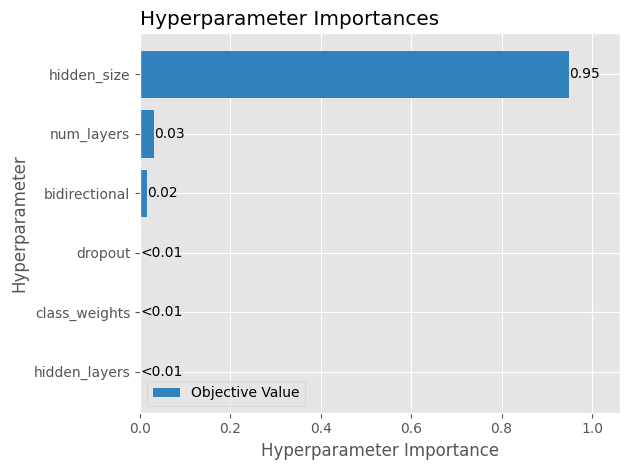

In [12]:
fig = optuna.visualization.matplotlib.plot_param_importances(study)
plt.tight_layout()
plt.show()

/tmp/ipykernel_313548/2926602762.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=['hidden_size', 'dropout', 'bidirectional'])
[W 2024-06-14 18:40:25,782] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


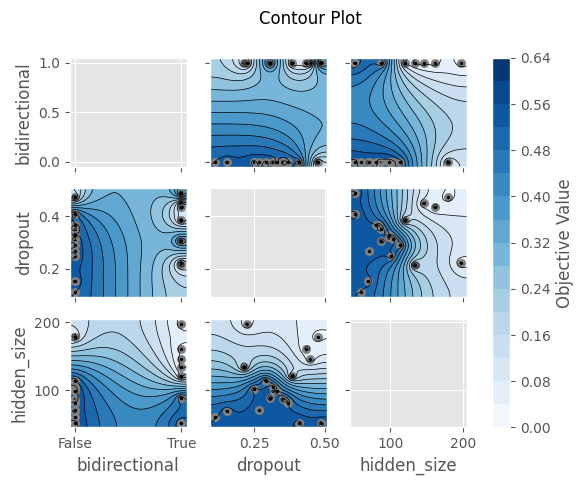

In [13]:
fig = optuna.visualization.matplotlib.plot_contour(study, params=['hidden_size', 'dropout', 'bidirectional'])
plt.show()